# Cluster the data and visualize
Following [this guide](https://www.askpython.com/python/examples/plot-k-means-clusters-python)

In [1]:
!pip install scikit-learn matplotlib mplcursors ipympl python-dotenv openai langchain
!pip install ipywidgets --upgrade

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
#Importing required modules
from typing import List, Tuple
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import json
import cluster

file_path = f"data_store/embeddings_seed_69420_size_10000.json"
embeddings: List[Tuple[str, List[float]]] = json.load(open(file_path, "r"))

N_EMBED_DIMS = len(embeddings[0][1])
N_CLUSTERS = 24
N_DIMS = N_EMBED_DIMS
SEED = 69420
df, label, u_labels = cluster.cluster(embeddings, n_clusters=N_CLUSTERS, dimensions=N_DIMS)

/home/lev/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [3]:
np.random.seed(SEED)
choices = np.random.choice(np.arange(len(df)), size=800)
colors = np.random.rand(N_CLUSTERS, 3)

In [4]:
%matplotlib ipympl
import textwrap
from mplcursors import cursor
import mplcursors
from matplotlib.text import Annotation

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)
c = np.random.randint(1,5,size=len(choices))

def plot_axis(dim : int):
    dim_1 = dim
    fig, ax = plt.subplots(figsize=(18,10))
    curr_ax = ax
    sc = curr_ax.scatter(df[choices, dim_1], np.zeros(len(choices)), color=colors[label[choices]])
    curr_ax.set_title(f"KMeans on Dimension {dim_1 + 1}")


    annot = curr_ax.annotate("", xy=(-0,0), xytext=(-80, 15), textcoords="offset points",
                    bbox=dict(boxstyle="round,pad=0.3", fc="w"),
                    arrowprops=dict(arrowstyle="->")
                    )
    annot.set_wrap(True)
    annot.set_visible(False)

    def update_annot(ind):

        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = "{}".format(" ".join([embeddings[n][0] for n in ind["ind"]]))
        wrapped_text = textwrap.fill(text, width=60)

        annot.set_text(wrapped_text)
        # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(1)


    def hover(event):
        # print("AAAA", event)
        vis = annot.get_visible()
        if event.inaxes is not None and event.inaxes == ax:
            # print("BBBB", event)
            # print(scs[0])
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
    fig.canvas.mpl_connect("motion_notify_event", hover)

In [5]:
# print("\n".join(get_theorems_in_group(0)[:20]))
# print("\n\n")

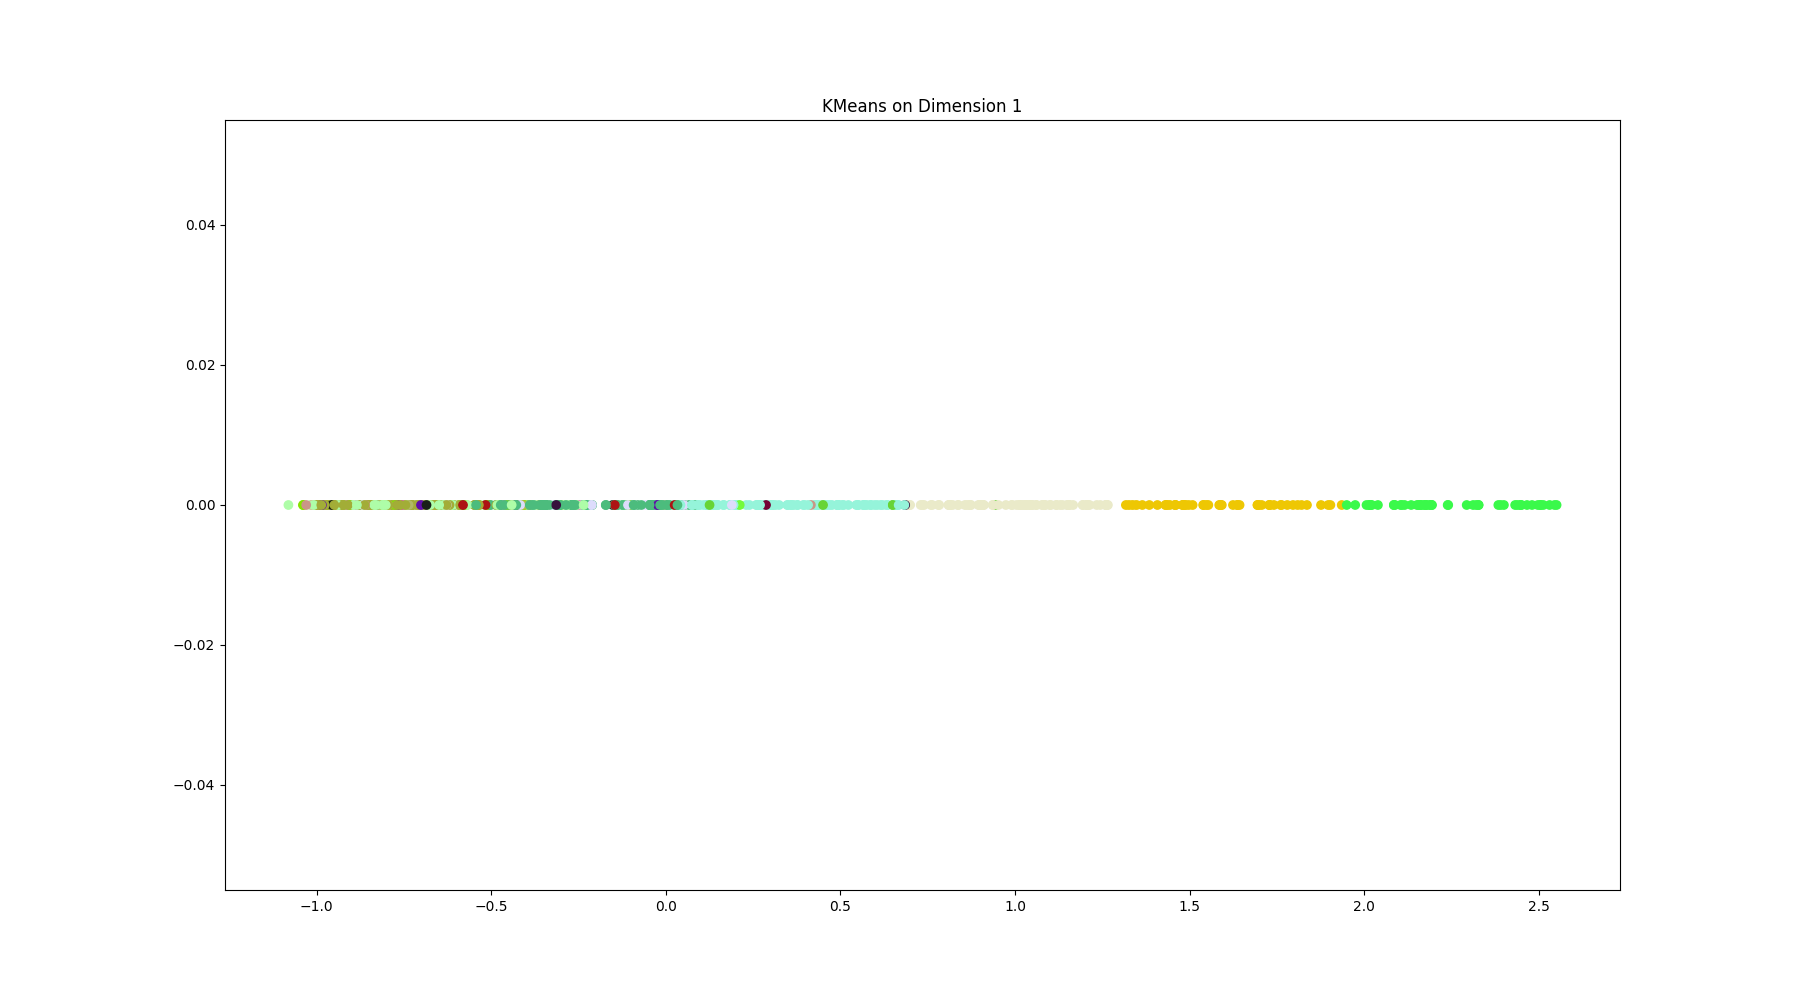

In [6]:
plot_axis(0)

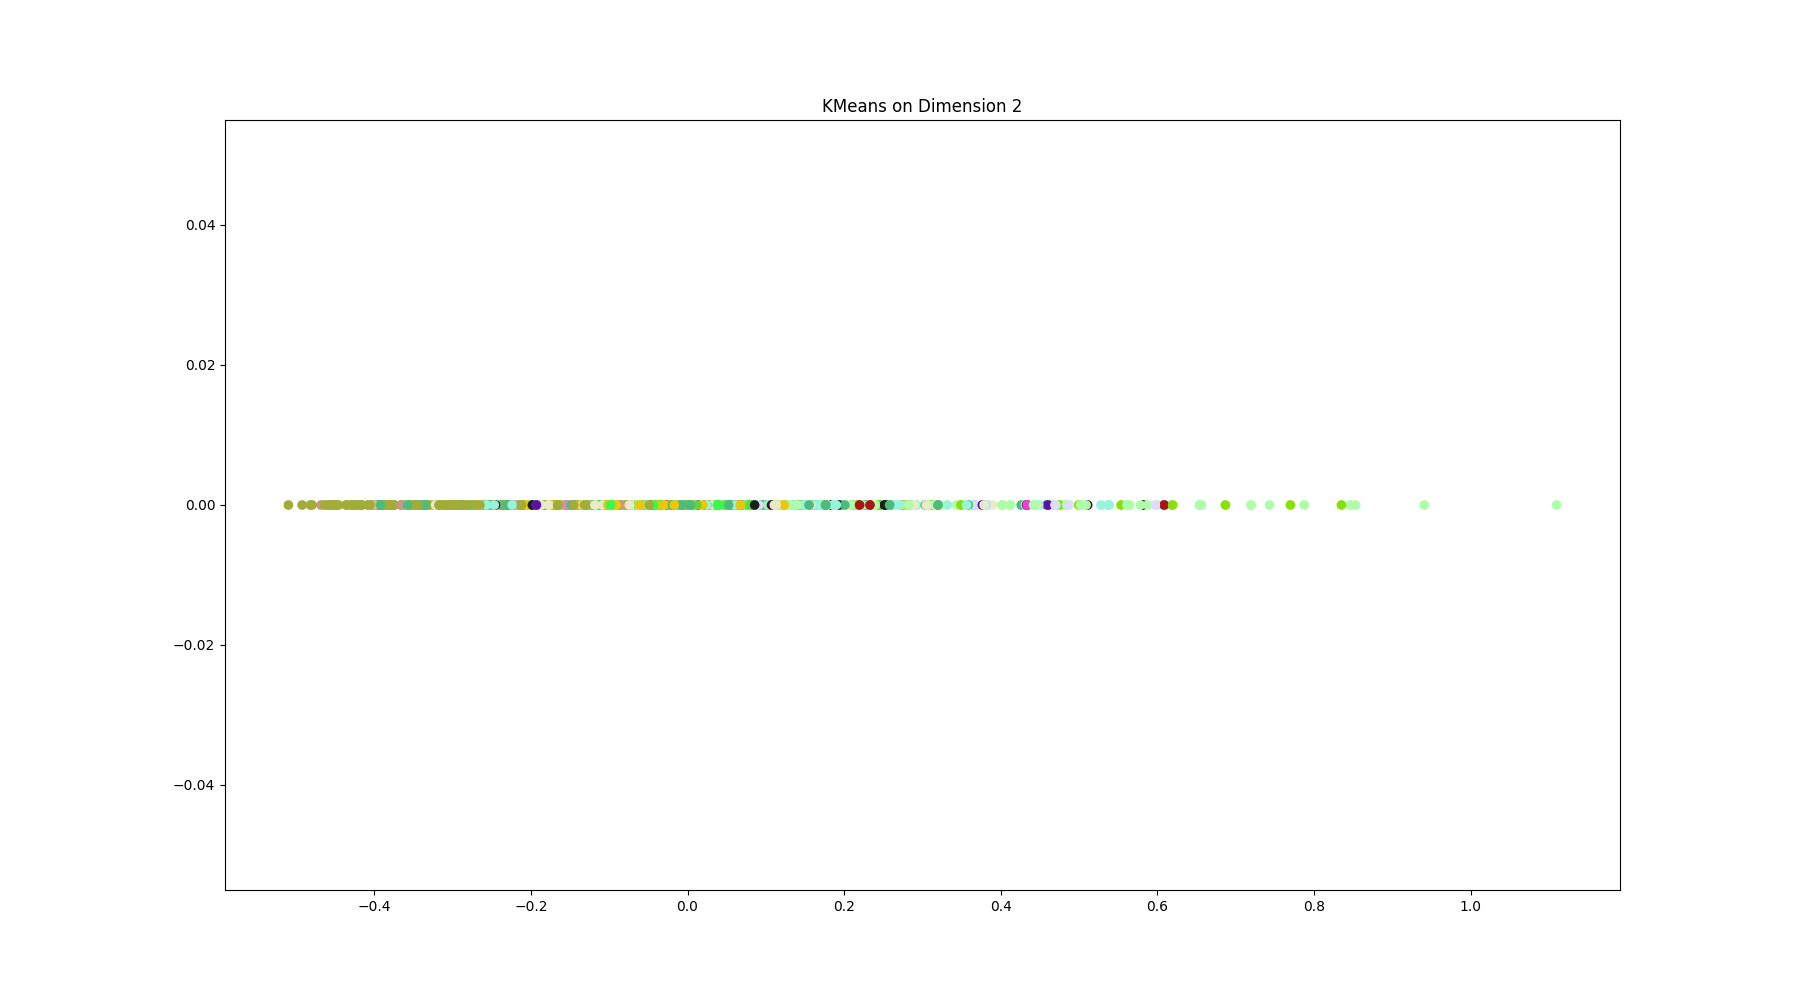

In [7]:
plot_axis(1)

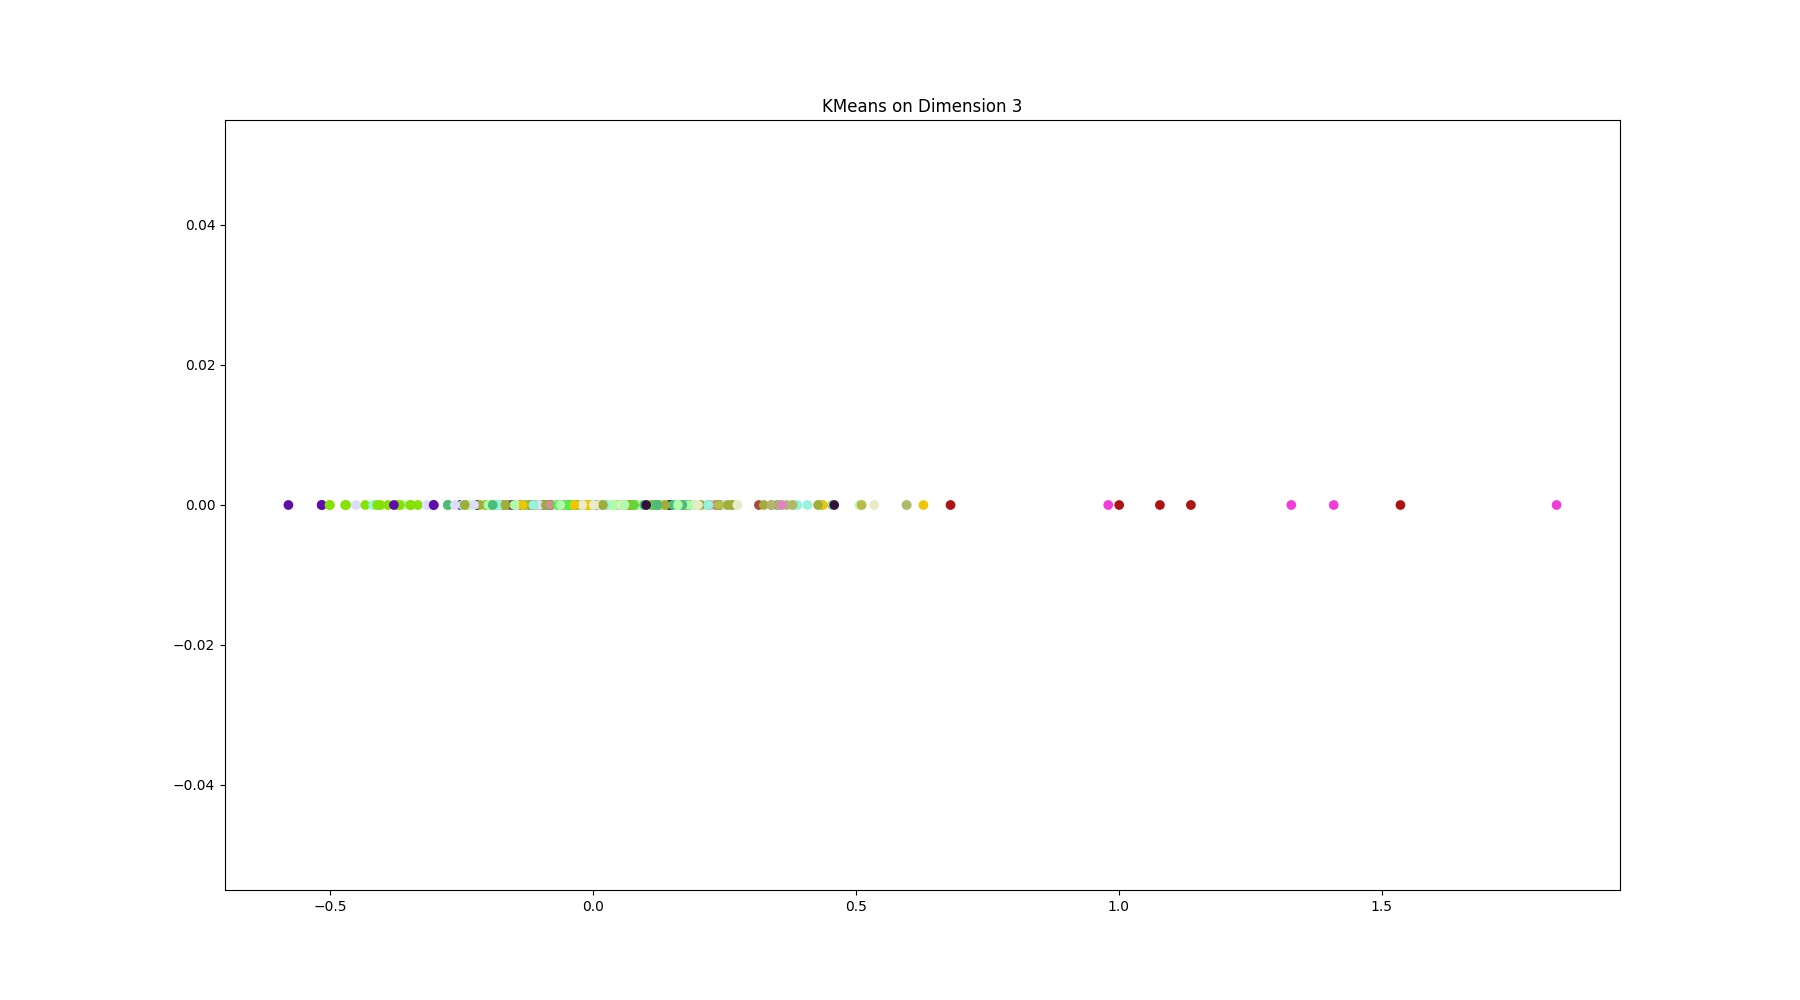

In [8]:
plot_axis(2)

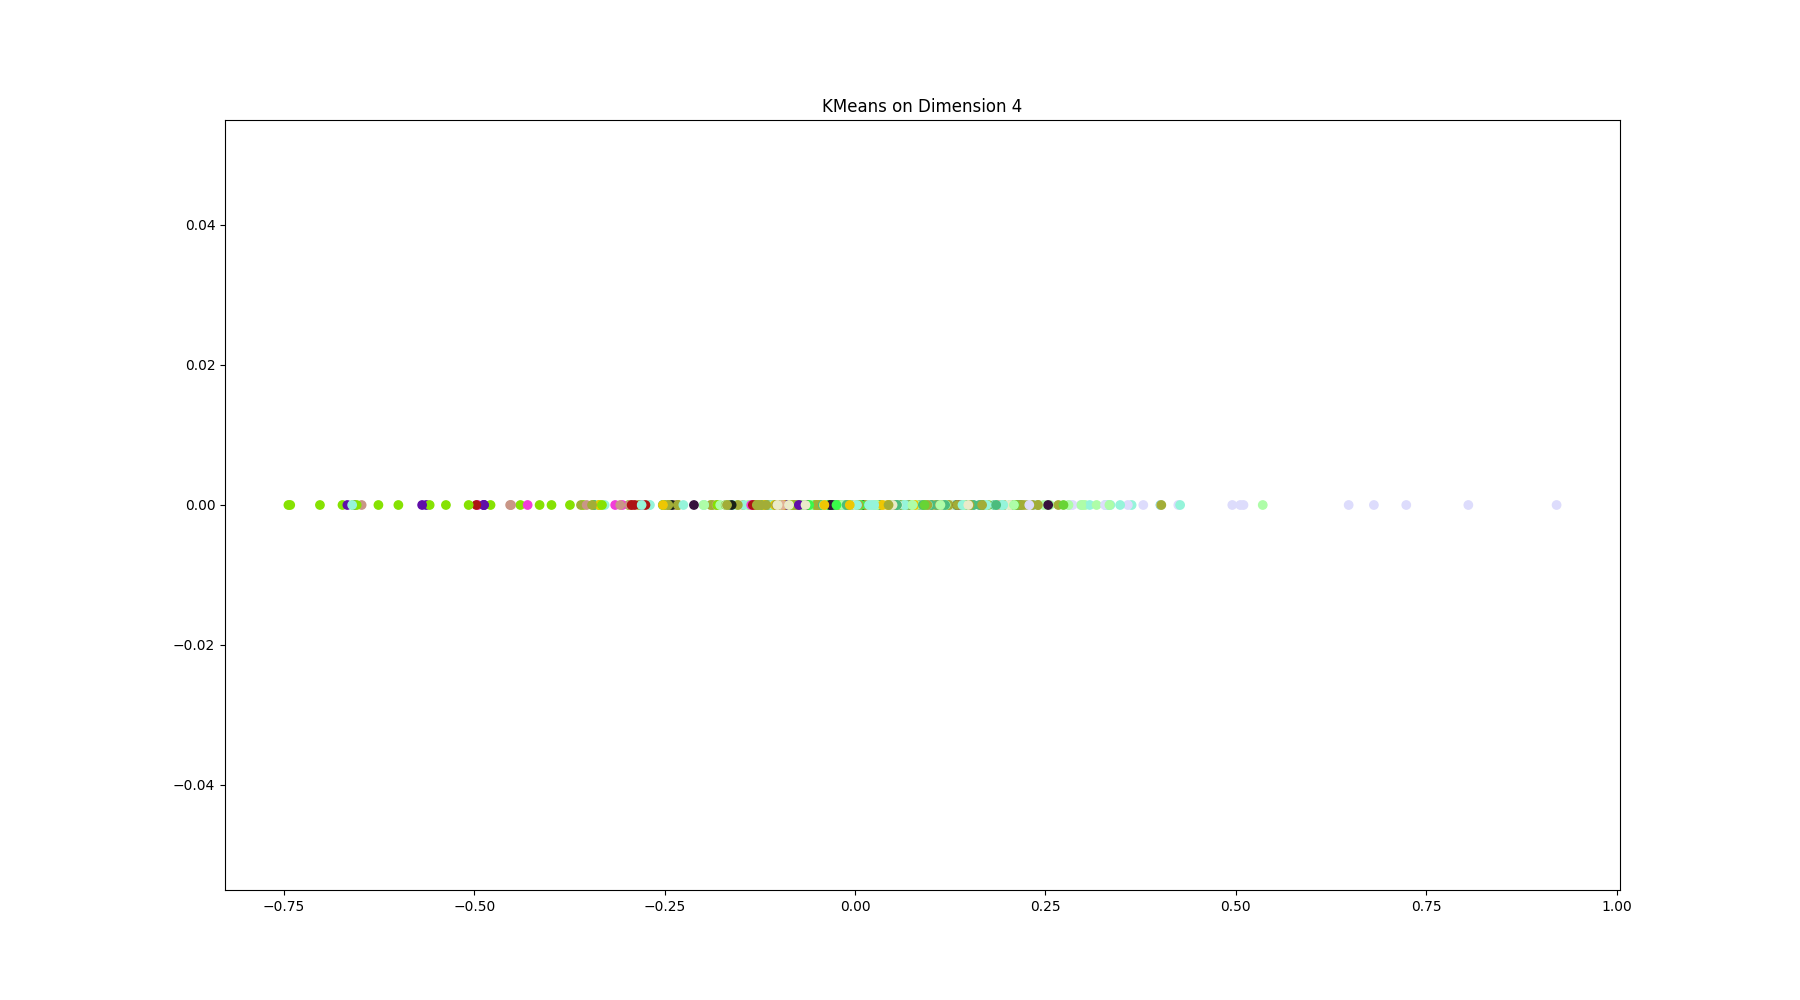

In [9]:
plot_axis(3)

In [10]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [11]:
import cluster

def get_theorems_in_group(group_idx: int, max_size=None, random=True):
	s = [embeddings[i][0] for i in np.where(label == group_idx)[0]]
	if max_size is None or len(s) <= max_size: 
		return s
	if not random:
		return s[:max_size]
	c = np.random.choice(np.arange(len(s)), size=max_size, replace=False)
	return [s[i] for i in c]

MAX_SIZE=20
get_theorems_in_group(6, max_size=MAX_SIZE)#, get_theorems_in_group(6, max_size=MAX_SIZE), i, j, api_key=OPENAI_API_KEY
# rel_0_1  = cluster.relative_labels(get_theorems_in_group(0, max_size=MAX_SIZE), get_theorems_in_group(1, max_size=MAX_SIZE), api_key=OPENAI_API_KEY)

['lemma whisker_right_left (F : B ⥤ C) {G H : C ⥤ D} (α : G ⟶ H) (K : D ⥤ E) :\n  whisker_right (whisker_left F α) K = whisker_left F (whisker_right α K)',
 'lemma trop_inj_iff (x y : R) : trop x = trop y ↔ x = y',
 'lemma lim_mul (f : cau_seq β abv) (x : β) : lim f * x = lim (f * const abv x)',
 'lemma mul [has_mul R] [is_scalar_tower R R M]\n  (ra : is_smul_regular M a) (rb : is_smul_regular M b) : is_smul_regular M (a * b)',
 'lemma nth_zip_with (f : α → β → γ) (l₁ : list α) (l₂ : list β) (i : ℕ) :\n  (zip_with f l₁ l₂).nth i = ((l₁.nth i).map f).bind (λ g, (l₂.nth i).map g)',
 'lemma image_id (s : set α) : image (@eq α) s = s',
 'lemma is_lower_set_Union₂ {f : Π i, κ i → set α} (hf : ∀ i j, is_lower_set (f i j)) :\n  is_lower_set (⋃ i j, f i j)',
 'theorem forall₂.nth_le :\n  ∀ {x : list α} {y : list β} (h : forall₂ R x y) ⦃i : ℕ⦄ (hx : i < x.length) (hy : i < y.length),\n      R (x.nth_le i hx) (y.nth_le i hy)',
 "theorem image_diff {f : α → β} (hf : injective f) (s t : set α) :\n

In [12]:
def get_all_differences():
	differences = []
	for i in range(N_CLUSTERS):
		for j in range(i):
			print(i, j)
			diffs = cluster.relative_labels(get_theorems_in_group(i, max_size=MAX_SIZE), get_theorems_in_group(j, max_size=MAX_SIZE), i, j, api_key=OPENAI_API_KEY)
			print(diffs)
			differences.append((i, j, diffs))
	return differences
j = {}
# j['differences'] = get_all_differences()
# j['differences'] = differences

In [13]:
# TODO: change to ture?
if False:
	j['theorems'] = [[
					[lab, embeddings[idx][0]] for idx in np.where(label == lab)[0].tolist()
			  ] for lab in range(N_CLUSTERS)]
	# get_all_differences()
	json.dump(j, open(f"data_store/differences_clustersize_{N_CLUSTERS}_seed_{SEED}.json", "w"))

## Assign a final label based off of differences

In [14]:
from langchain import OpenAI

def get_label(centroid_idx: int, differences: List[Tuple[int, int, str]]):
	related_diffs = []
	for i, j, diffs in differences:
		if i == centroid_idx or j == centroid_idx:
			related_diffs.append(diffs)
	label = "Set Cluster " + str(centroid_idx)
	prompt = "Given the following differences between different sets of two cluster, what is the primary focus of " + label + """ in one sentence?

""" + "\n".join(related_diffs) + """

PRIMARY FOCUS:"""
	llm = OpenAI(model_name="gpt-4", openai_api_key=OPENAI_API_KEY)
	ret = llm(prompt)
	return ret


In [15]:
def get_and_save_all_labels():
	llm_labels = []
	for i in range(N_CLUSTERS):
		llm_labels.append(get_label(i, j['differences']))
	j["llm_labels"] = llm_labels
	json.dump(j, open(f"data_store/differences_clustersize_{N_CLUSTERS}_seed_{SEED}.json", "w"))
# get_and_save_all_labels()

## Now lets try a "BP" based approach

In [16]:
import numbers

# From https://github.com/hichamjanati/pyldpc, but modified to make a square matrix
def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance
    Parameters
    ----------
    seed : None | int | instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)

def parity_check_matrix(n_code, d_v, d_c, seed=None):
    """
    Build a regular Parity-Check Matrix H following Callager's algorithm.

    Parameters
    ----------
    n_code: int, Length of the codewords.
    d_v: int, Number of parity-check equations including a certain bit.
        Must be greater or equal to 2.
    d_c: int, Number of bits in the same parity-check equation. d_c Must be
        greater or equal to d_v and must divide n.
    seed: int, seed of the random generator.

    Returns
    -------
    H: array (n_equations, n_code). LDPC regular matrix H.
        Where n_equations = d_v * n / d_c, the total number of parity-check
        equations.

    """
    rng = check_random_state(seed)

    if d_v <= 1:
        raise ValueError("""d_v must be at least 2.""")

    # if d_c <= d_v:
    #     raise ValueError("""d_c must be greater than d_v.""")

    if n_code % d_c:
        raise ValueError("""d_c must divide n for a regular LDPC matrix H.""")

    n_equations = (n_code * d_v) // d_c

    block = np.zeros((n_equations // d_v, n_code), dtype=int)
    H = np.empty((n_equations, n_code))
    block_size = n_equations // d_v

    # Filling the first block with consecutive ones in each row of the block

    for i in range(block_size):
        for j in range(i * d_c, (i+1) * d_c):
            block[i, j] = 1
    H[:block_size] = block

    # reate remaining blocks by permutations of the first block's columns:
    for i in range(1, d_v):
        H[i * block_size: (i + 1) * block_size] = rng.permutation(block.T).T
    H = H.astype(int)
    return H

parity_check_matrix(16, 4, 4)

array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]])

In [17]:
import numpy as np

cluster_cluster_deg = 3
# Half of the clusters are "parity checks" and the rest are "bits"
H= parity_check_matrix(int(N_CLUSTERS / 2), cluster_cluster_deg, cluster_cluster_deg, seed=SEED)
H

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]])

In [18]:
# Get the bit indices and the parity check indices
parity_check_inds = np.random.choice(np.arange(N_CLUSTERS), size=int(N_CLUSTERS / 2), replace=False)
bit_inds = np.array(list(filter(lambda x: x not in parity_check_inds, np.arange(N_CLUSTERS))))
np.random.shuffle(bit_inds)
bit_inds, parity_check_inds

(array([23, 12, 14, 20, 21,  6,  4, 16, 22, 11,  1,  8]),
 array([ 5, 18,  9,  0,  7, 15,  3,  2, 19, 13, 17, 10]))

In [21]:
import cluster
import asyncio
import copy
import numpy.typing as npt
from typing import List
# Jank BP-esque LLM message passing algorithm
# MODEL_NAME = "gpt-3.5-turbo-16k" # Use GPT-4 later
MODEL_NAME = "gpt-4"

llm = OpenAI(model_name=MODEL_NAME, openai_api_key=OPENAI_API_KEY)

def get_data_file_name():
	return f"data_store/llm_bp_clustersize_{N_CLUSTERS}_seed_{SEED}_{MODEL_NAME}.json"

def save_dict(d: dict):
	json.dump(d, open(get_data_file_name(), "w"))

# TODO: there does not seem to be much distinction between the parity checks and the bits
async def llm_bp(H_cluster: npt.NDArray, bit_inds: npt.ArrayLike, check_inds: npt.ArrayLike, n_rounds: int, dict_out = {}):

	# For simplicity, we will use an adjacency matrix for now. Later we can flatten this data-structure to make it cheaper
	if "rounds" in dict_out and len(dict_out["rounds"]) > 0:
		primary_focuses_msgs_last = dict_out["rounds"][-1]
	else:
		primary_focuses_msgs_last = [["" for _ in range(N_CLUSTERS)] for _ in range(N_CLUSTERS)]
	# primary_focuses_msgs = [["" for _ in range(N_CLUSTERS)] for _ in range(N_CLUSTERS)]

	async def pc_to_bit(i):
		H_ind = np.where(check_inds == i)[0][0]
		neighbors = np.where(H_cluster[H_ind, :] == 1)
		cluster_neighbor_inds = bit_inds[neighbors]
		p = ["" for _ in range(N_CLUSTERS)]

		for neighbor_ind in range(cluster_cluster_deg):
			neighbors_without_neighbor = np.delete(cluster_neighbor_inds, neighbor_ind)
			
			ret = await cluster.local_neighbor_with_descr_labels(get_theorems_in_group(i, max_size=MAX_SIZE), primary_focuses_msgs_last[i],
																[get_theorems_in_group(j, max_size=MAX_SIZE)
																for j in neighbors_without_neighbor], [primary_focuses_msgs_last[j][i] for j in neighbors_without_neighbor], llm=llm)
			
			# primary_focuses_msgs[i][cluster_neighbor_inds[neighbor_ind]] = ret
			p[cluster_neighbor_inds[neighbor_ind]] = ret
		return (i, p)
	
	async def bit_to_pc(i):
		H_ind = np.where(bit_inds == i)[0][0]
		neighbors = np.where(H_cluster[H_ind, :] == 1)
		cluster_neighbor_inds = check_inds[neighbors]
		p = ["" for _ in range(N_CLUSTERS)]

		for neighbor_ind in range(cluster_cluster_deg):
			neighbors_without_neighbor = np.delete(cluster_neighbor_inds, neighbor_ind)
			
			ret = await cluster.local_neighbor_with_descr_labels(get_theorems_in_group(i, max_size=MAX_SIZE), primary_focuses_msgs_last[i],
																[get_theorems_in_group(j, max_size=MAX_SIZE)
																for j in neighbors_without_neighbor], [primary_focuses_msgs_last[j][i] for j in neighbors_without_neighbor], llm=llm)
			# primary_focuses_msgs[i][cluster_neighbor_inds[neighbor_ind]] = ret
			p[cluster_neighbor_inds[neighbor_ind]] = ret
		print("DONE WITH", i)
		return (i, p)

	# dict_out["rounds"].append(copy.deepcopy(primary_focuses))
	# save_dict(dict_out)
	if "rounds" not in dict_out:
		dict_out["rounds"] = []
	for round_numb in range(n_rounds): # < n_rounds * 2
		print(f"BP Round {round_numb + 1} out of {n_rounds}")
		dict_out["rounds"].append([])
		tasks = []
		for i in range(N_CLUSTERS):
			if i in bit_inds:
				tasks.append(bit_to_pc(i))
				# primary_focuses_msgs[i] = p
			else:
				tasks.append(pc_to_bit(i))
			print("Appended cluster", i)

		tmp = await asyncio.gather(*tasks)
		primary_focuses_msgs =  [a[1] for a in tmp]
		print(primary_focuses_msgs)
		dict_out["rounds"][-1] = primary_focuses_msgs
		save_dict(dict_out)
		primary_focuses_msgs_last = copy.deepcopy(primary_focuses_msgs)
		save_dict(dict_out)
	return dict_out

/home/lev/.local/lib/python3.9/site-packages/langchain/llms/openai.py:200: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/home/lev/.local/lib/python3.9/site-packages/langchain/llms/openai.py:787: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


In [22]:
d_out = json.load(open(get_data_file_name(), "r")) if os.path.exists(get_data_file_name()) else {}
print(d_out)
ROUNDS = 3
await llm_bp(H, bit_inds, parity_check_inds, ROUNDS, d_out)

{'rounds': [[['', '', '', '', '', '', '', 'The primary theorems in this set focus on various topics such as set operations, list manipulation, properties of numbers, and algebraic structures. Some of the primary theorems discuss specific properties of sets, such as the commutativity of pairs, the equivalence between membership in a set and an option type, and the intersection of sets. Others focus on list operations, such as reversing a list, rotating a list, and mapping functions over lists. There are also primary theorems related to properties of numbers, such as divisibility, counting occurrences of elements, and the relationship between prime numbers and powers. Lastly, there are primary theorems related to algebraic structures, such as properties of ring homomorphisms and applicative transformations. \n\nIn contrast, the non-primary theorems in this set are a mix of lemmas and theorems that cover a wide range of topics. These non-primary theorems include properties of the modulo o

DONE WITH 8
DONE WITH 4
DONE WITH 20
DONE WITH 22
DONE WITH 1
DONE WITH 11
DONE WITH 23
DONE WITH 16
DONE WITH 12
DONE WITH 14
DONE WITH 6
DONE WITH 21
[['', 'The main focus of the primary theorems is on various topics such as set operations, list manipulation, properties of numbers, and algebraic structures. Some of the primary theorems discuss specific properties of sets, such as the commutativity of pairs, the equivalence between membership in a set and an option type, and the intersection of sets. Others focus on list operations, such as reversing a list, rotating a list, and mapping functions over lists. There are also primary theorems related to properties of numbers, such as divisibility, counting occurrences of elements, and the relationship between prime numbers and powers. Lastly, there are primary theorems related to algebraic structures, such as properties of ring homomorphisms and applicative transformations.\n\nIn contrast, the non-primary theorems in this set are a mix o

Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 177744 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 178880 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 18

DONE WITH 8
DONE WITH 11
DONE WITH 16


Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 179122 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 178946 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 18

DONE WITH 12


Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 177488 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 179175 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 18

DONE WITH 14
DONE WITH 4


Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 178877 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 178740 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 18

DONE WITH 20
DONE WITH 6
DONE WITH 22
DONE WITH 23
DONE WITH 1
DONE WITH 21
[['', 'The main focus of the primary theorems is on various topics such as set operations, list manipulation, properties of numbers, and algebraic structures. Some of the primary theorems discuss specific properties of sets, such as the commutativity of pairs, the equivalence between membership in a set and an option type, and the intersection of sets. Others focus on list operations, such as reversing a list, rotating a list, and mapping functions over lists. There are also primary theorems related to properties of numbers, such as divisibility, counting occurrences of elements, and the relationship between prime numbers and powers. Lastly, there are primary theorems related to algebraic structures, such as properties of ring homomorphisms and applicative transformations.\n\nIn contrast, the non-primary theorems in this set are a mix of lemmas and theorems that cover a wide range of topics. These non-primary t

Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 177565 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 179716 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 18

DONE WITH 6


Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 179034 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 178945 / min. Contact us through our help center at help.openai.com if you continue to have issues..


DONE WITH 4


Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 179657 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 179349 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 18

DONE WITH 16


Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 178169 / min. Contact us through our help center at help.openai.com if you continue to have issues..


DONE WITH 23
DONE WITH 11
DONE WITH 12


Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 179853 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 180000 / min. Current: 178918 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-R15P1JlYhXpLEYQoltt6MxA4 on tokens per min. Limit: 18

DONE WITH 20
DONE WITH 1
DONE WITH 22
DONE WITH 8
DONE WITH 21
DONE WITH 14
[['', 'The focus of the primary theorems is on various topics such as set operations, list manipulation, properties of numbers, and algebraic structures. Some of the primary theorems discuss specific properties of sets, such as the commutativity of pairs, the equivalence between membership in a set and an option type, and the intersection of sets. Others focus on list operations, such as reversing a list, rotating a list, and mapping functions over lists. There are also primary theorems related to properties of numbers, such as divisibility, counting occurrences of elements, and the relationship between prime numbers and powers. Lastly, there are primary theorems related to algebraic structures, such as properties of ring homomorphisms and applicative transformations.\n\nIn contrast, the non-primary theorems in this set cover a wider range of topics. These non-primary theorems include properties of the modulo o

{'rounds': [[['',
    '',
    '',
    '',
    '',
    '',
    '',
    'The primary theorems in this set focus on various topics such as set operations, list manipulation, properties of numbers, and algebraic structures. Some of the primary theorems discuss specific properties of sets, such as the commutativity of pairs, the equivalence between membership in a set and an option type, and the intersection of sets. Others focus on list operations, such as reversing a list, rotating a list, and mapping functions over lists. There are also primary theorems related to properties of numbers, such as divisibility, counting occurrences of elements, and the relationship between prime numbers and powers. Lastly, there are primary theorems related to algebraic structures, such as properties of ring homomorphisms and applicative transformations. \n\nIn contrast, the non-primary theorems in this set are a mix of lemmas and theorems that cover a wide range of topics. These non-primary theorems includ

In [23]:
def save_thms():
	d_out['thm_clusters'] = [
		np.where(label == group_idx)[0].tolist() for group_idx in range(N_CLUSTERS)
	]
	save_dict(d_out)
save_thms()

In [26]:
def shorten(node_idx: int, ind: int):
	# ind = 0
	last_msgs = filter(lambda a: a != "", d_out["rounds"][ind][node_idx])
	joined = "\n".join(last_msgs)
	prompt = f"""Given the following descriptions of a primary set and the differences between a primary set of theorems and an adjacent set of theorems, what is the primary focus of the primary set of theorems in one sentence?

DIFFERENCES: "{joined}"

SHORTENED PRIMARY FOCUS:"""
	return llm(prompt)

def shorten_all():
	if "shortened" not in d_out:
		d_out["shortened"] = []
	ind = -1
	d_out["shortened"].append([])
	d_out["shortened"][-1] = ["BP Round " + str((len(d_out["rounds"]) + ind) % len(d_out["rounds"])), []]
	for i in range(N_CLUSTERS):
		d_out["shortened"][-1][1].append(shorten(i, -1))
		save_dict(d_out)

shorten_all()
# We can check out **how much** having consecutive rounds matters via shortening different message rounds

## Check manually if the cluster labels match the set

In [51]:
def check_subset(cluster_ind: int):
	thms = get_theorems_in_group(cluster_ind, max_size=5)
	print("Theorems:\n", thms)
	cluster_descr = d_out["shortened"][-1][1][cluster_ind]
	print("Cluster Description:\n", cluster_descr)
check_subset(22)

Theorems:
 ['lemma mem_pi (m : multiset α) (t : Πa, multiset (β a)) :\n  ∀f:Πa∈m, β a, (f ∈ pi m t) ↔ (∀a (h : a ∈ m), f a h ∈ t a)', "lemma preimage_pi_equiv_pi_subtype_prod_symm_pi {α : Type*} {β : α → Type*}\n  (p : α → Prop) [decidable_pred p] (s : Π i, set (β i)) :\n  (pi_equiv_pi_subtype_prod p β).symm ⁻¹' pi univ s =\n    (pi univ (λ i : {i // p i}, s i)) ×ˢ pi univ (λ i : {i // ¬p i}, s i)", "lemma univ_pi_update_univ [decidable_eq ι] (i : ι) (s : set (α i)) :\n  pi univ (update (λ j : ι, (univ : set (α j))) i s) = eval i ⁻¹' s", "lemma pi_congr (h : s₁ = s₂) (h' : ∀ i ∈ s₁, t₁ i = t₂ i) : s₁.pi t₁ = s₂.pi t₂", 'lemma pi_mono (h : ∀ i ∈ s, t₁ i ⊆ t₂ i) : pi s t₁ ⊆ pi s t₂']
Cluster Description:
 The primary focus of the primary set of theorems is on the properties and operations related to the infimum (∧) operation in various mathematical structures.
